In [ ]:
import scipy.io as scipy
import numpy as np
import matplotlib.pyplot as plt
import librosa
from sklearn import preprocessing
import tensorflow as tf
import os
import librosa.display

In [ ]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
a = '/content/drive/MyDrive/Inertial/a'
b = '_s'
c = '_t'
d = '_inertial.mat'

file_list = []
for i in range(10,20):
  for j in range(1,9):
    for k in range(1,5):
      file_path = a + str(i)+b+str(j)+c+str(k)+d
      file_list.append(file_path)
for i in range(1,2):
  for j in range(1,9):
    for k in range(1,5):
      file_path = a + str(i)+b+str(j)+c+str(k)+d
      file_list.append(file_path)
for i in range(20,28):
  for j in range(1,9):
    for k in range(1,5):
      file_path = a + str(i)+b+str(j)+c+str(k)+d
      file_list.append(file_path)
for i in range(2,10):
  for j in range(1,9):
    for k in range(1,5):
      file_path = a + str(i)+b+str(j)+c+str(k)+d
      file_list.append(file_path)
file_list.remove('/content/drive/MyDrive/Inertial/a8_s1_t4_inertial.mat')
file_list.remove('/content/drive/MyDrive/Inertial/a23_s6_t4_inertial.mat')
file_list.remove('/content/drive/MyDrive/Inertial/a27_s8_t4_inertial.mat')

In [ ]:
def melspectrum(data):
        data_x = data[:,0]
        data_y = data[:,1]
        data_z = data[:,2]
        data_x = data_x.reshape(-1)
        data_y = data_y.reshape(-1)
        data_z = data_z.reshape(-1)
        data_xx = np.interp(np.linspace(0, data_x.size, 10000), np.arange(data_x.size), data_x)
        Sx = librosa.feature.melspectrogram(y=data_xx, sr=100)
        Sx_dB = librosa.power_to_db(Sx, ref=np.max)
        data_yy = np.interp(np.linspace(0, data_y.size, 10000), np.arange(data_y.size), data_y)
        Sy = librosa.feature.melspectrogram(y=data_yy, sr=100)
        Sy_dB = librosa.power_to_db(Sy, ref=np.max)
        data_zz = np.interp(np.linspace(0, data_z.size, 10000), np.arange(data_z.size), data_z)
        Sz = librosa.feature.melspectrogram(y=data_zz, sr=100)
        Sz_dB = librosa.power_to_db(Sz, ref=np.max)
        S_db = np.dstack((Sx_dB, Sy_dB, Sz_dB))
        S_norm = S_db-S_db.min()
        S_norm /= S_norm.max()
        return S_norm

In [ ]:
def load_data(data_directory):
    file_names = file_list
    train_labels = []
    train_datas = []
    test_labels = []
    test_datas = []
    train_split = [1,3,5,7]
    for d in file_names:
        label = d[-21:-19]
        if 'a' in label[0]:
            label = label[-1]
        label = int(label)
        if label == 27:
          label = 0
        if int(d[-17:-16]) in train_split:
            train_labels.append(label)
            data = scipy.loadmat(d)
            data = data['d_iner'][:,:3]
            S_norm = melspectrum(data)
            train_datas.append(S_norm)
        else:
            test_labels.append(label)
            data = scipy.loadmat(d)
            data = data['d_iner'][:,:3]
            S_norm = melspectrum(data)
            test_datas.append(S_norm) 
    train_labels = np.array(train_labels)
    train_datas = np.array(train_datas)
    test_labels = np.array(test_labels)
    test_datas = np.array(test_datas)
    return train_labels,train_datas,test_labels,test_datas

**skeleton data preprocessing**

In [ ]:
def images_creater(file):
    data = scipy.loadmat(file)
    data = data['d_skel']
    x_images = data[0,0,:]
    y_images = data[0,0,:]
    z_images = data[0,0,:]
    for i in range(20):
        for j in range(3):
            if j == 0:
                x_images = np.vstack((x_images,data[i,j,:]))
            elif j == 1:
                y_images = np.vstack((y_images,data[i,j,:]))
            else:
                z_images = np.vstack((z_images,data[i,j,:]))
    x_images=x_images[1:,:]
    y_images=y_images[1:,:]
    z_images=z_images[1:,:]
    v_x = np.lib.stride_tricks.sliding_window_view(x_images,(20,40))
    v_y = np.lib.stride_tricks.sliding_window_view(y_images,(20,40))
    v_z = np.lib.stride_tricks.sliding_window_view(z_images,(20,40))
    v_squeeze = v_x.squeeze()
    v_x = np.expand_dims(v_squeeze,axis=-1)
    v_squeeze = v_y.squeeze()
    v_y = np.expand_dims(v_squeeze,axis=-1)
    v_squeeze = v_z.squeeze()
    v_z = np.expand_dims(v_squeeze,axis=-1)
    v_expand = np.concatenate((v_x,v_y,v_z), axis=3)

    label = file[-21:-19]
    if 'a' in label[0]:
        label = label[-1]
    label=int(label)
    if label == 27:
        label = 0
    labels = np.zeros(v_expand.shape[0],dtype = 'int32')
    for i in range(v_expand.shape[0]):
        labels[i] = label
    return v_expand,labels

In [ ]:
a = '/content/drive/MyDrive/Skeleton/a'
b = '_s'
c = '_t'
d = '_skeleton.mat'
file_list_skeleton = []
for i in range(10,20):
  for j in range(1,9):
    for k in range(1,5):
      file_path = a + str(i)+b+str(j)+c+str(k)+d
      file_list_skeleton.append(file_path)
for i in range(1,2):
  for j in range(1,9):
    for k in range(1,5):
      file_path = a + str(i)+b+str(j)+c+str(k)+d
      file_list_skeleton.append(file_path)
for i in range(20,28):
  for j in range(1,9):
    for k in range(1,5):
      file_path = a + str(i)+b+str(j)+c+str(k)+d
      file_list_skeleton.append(file_path)
for i in range(2,10):
  for j in range(1,9):
    for k in range(1,5):
      file_path = a + str(i)+b+str(j)+c+str(k)+d
      file_list_skeleton.append(file_path)
file_list_skeleton.remove('/content/drive/MyDrive/Skeleton/a23_s6_t4_skeleton.mat')
file_list_skeleton.remove('/content/drive/MyDrive/Skeleton/a27_s8_t4_skeleton.mat')
file_list_skeleton.remove('/content/drive/MyDrive/Skeleton/a8_s1_t4_skeleton.mat')

In [ ]:
def load_skeleton_data(data_directory):
    file_names = file_list_skeleton
    path = '/content/drive/MyDrive/Skeleton/a1_s1_t1_skeleton.mat'
    images,labels = images_creater(path)
    train_datas = images
    train_labels = labels
    test_datas = images
    test_labels = labels
    train_split = [1,3,5,7]
    for d in file_names:
        images,labels = images_creater(d)
        if int(d[-17:-16]) in train_split:
            train_labels = np.append(train_labels,labels,axis = 0)
            train_datas = np.append(train_datas,images,axis = 0)
        else:
            test_labels = np.append(test_labels,labels,axis = 0)
            test_datas = np.append(test_datas,images,axis = 0)
    train_datas = train_datas[29:,:,:,:]    
    test_datas = test_datas[29:,:,:,:]
    test_labels = test_labels[29:]
    train_labels = train_labels[29:]
    return train_labels,train_datas,test_labels,test_datas

In [ ]:
interial_directory = '/content/drive/MyDrive/Inertial'
train_y1,train_x1,test_y1,test_x1 = load_data(interial_directory)

In [ ]:
skeleton_directory = '/content/drive/MyDrive/Skeleton'
train_y2,train_x2,test_y2,test_x2 = load_skeleton_data(skeleton_directory)

In [ ]:
n = 15
train_x21 = train_x2[::n, ...]
train_y21 = train_y2[::n, ...]
test_x21 = test_x2[::n, ...]
test_y21 = test_y2[::n, ...]
print(train_y21.shape)
print(train_x21.shape)
print(test_y21.shape)
print(test_x21.shape)

(825,)
(825, 20, 40, 3)
(821,)
(821, 20, 40, 3)


In [ ]:
train_xnew1 = train_x21[:16]
train_ynew1 = train_y21[:16]
train_xx = np.concatenate((train_x21[:16], train_x21[37:53]))
train_yy = np.concatenate((train_y21[:16], train_y21[37:53]))
train_xx = np.concatenate((train_xx, train_x21[75:91]))
train_yy = np.concatenate((train_yy, train_y21[75:91]))
train_xx = np.concatenate((train_xx, train_x21[118:134]))
train_yy = np.concatenate((train_yy, train_y21[118:134]))
train_xx = np.concatenate((train_xx, train_x21[151:167]))
train_yy = np.concatenate((train_yy, train_y21[151:167]))
train_xx = np.concatenate((train_xx, train_x21[191:207]))
train_yy = np.concatenate((train_yy, train_y21[191:207]))
train_xx = np.concatenate((train_xx, train_x21[219:235]))
train_yy = np.concatenate((train_yy, train_y21[219:235]))
train_xx = np.concatenate((train_xx, train_x21[239:255]))
train_yy = np.concatenate((train_yy, train_y21[239:255]))
train_xx = np.concatenate((train_xx, train_x21[271:287]))
train_yy = np.concatenate((train_yy, train_y21[271:287]))
train_xx = np.concatenate((train_xx, train_x21[293:309]))
train_yy = np.concatenate((train_yy, train_y21[293:309]))
train_xx = np.concatenate((train_xx, train_x21[321:337]))
train_yy = np.concatenate((train_yy, train_y21[321:337]))
train_xx = np.concatenate((train_xx, train_x21[342:358]))
train_yy = np.concatenate((train_yy, train_y21[342:358]))
train_xx = np.concatenate((train_xx, train_x21[365:381]))
train_yy = np.concatenate((train_yy, train_y21[365:381]))
train_xx = np.concatenate((train_xx, train_x21[411:427]))
train_yy = np.concatenate((train_yy, train_y21[411:427]))
train_xx = np.concatenate((train_xx, train_x21[445:461]))
train_yy = np.concatenate((train_yy, train_y21[445:461]))
train_xx = np.concatenate((train_xx, train_x21[483:499]))
train_yy = np.concatenate((train_yy, train_y21[483:499]))
train_xx = np.concatenate((train_xx, train_x21[499:515]))
train_yy = np.concatenate((train_yy, train_y21[499:515]))
train_xx = np.concatenate((train_xx, train_x21[517:533]))
train_yy = np.concatenate((train_yy, train_y21[517:533]))
train_xx = np.concatenate((train_xx, train_x21[561:577]))
train_yy = np.concatenate((train_yy, train_y21[561:577]))
train_xx = np.concatenate((train_xx, train_x21[609:625]))
train_yy = np.concatenate((train_yy, train_y21[609:625]))
train_xx = np.concatenate((train_xx, train_x21[629:645]))
train_yy = np.concatenate((train_yy, train_y21[629:645]))
train_xx = np.concatenate((train_xx, train_x21[657:673]))
train_yy = np.concatenate((train_yy, train_y21[657:673]))
train_xx = np.concatenate((train_xx, train_x21[679:695]))
train_yy = np.concatenate((train_yy, train_y21[679:695]))
train_xx = np.concatenate((train_xx, train_x21[703:719]))
train_yy = np.concatenate((train_yy, train_y21[703:719]))
train_xx = np.concatenate((train_xx, train_x21[733:749]))
train_yy = np.concatenate((train_yy, train_y21[733:749]))
train_xx = np.concatenate((train_xx, train_x21[764:779]))
train_yy = np.concatenate((train_yy, train_y21[764:779]))
train_xx = np.concatenate((train_xx, train_x21[785:801]))
train_yy = np.concatenate((train_yy, train_y21[785:801]))
print(train_xx.shape)
print(train_yy.shape)

(431, 20, 40, 3)
(431,)


In [ ]:
test_xnew1 = test_x21[:16]
test_ynew1 = test_y21[:16]
test_xx = np.concatenate((test_x21[:16], test_x21[37:53]))
test_yy = np.concatenate((test_y21[:16], test_y21[37:53]))
test_xx = np.concatenate((test_xx, test_x21[80:96]))
test_yy = np.concatenate((test_yy, test_y21[80:96]))
test_xx = np.concatenate((test_xx, test_x21[117:133]))
test_yy = np.concatenate((test_yy, test_y21[117:133]))
test_xx = np.concatenate((test_xx, test_x21[148:164]))
test_yy = np.concatenate((test_yy, test_y21[148:164]))
test_xx = np.concatenate((test_xx, test_x21[183:199]))
test_yy = np.concatenate((test_yy, test_y21[183:199]))
test_xx = np.concatenate((test_xx, test_x21[208:224]))
test_yy = np.concatenate((test_yy, test_y21[208:224]))
test_xx = np.concatenate((test_xx, test_x21[231:247]))
test_yy = np.concatenate((test_yy, test_y21[231:247]))
test_xx = np.concatenate((test_xx, test_x21[261:277]))
test_yy = np.concatenate((test_yy, test_y21[261:277]))
test_xx = np.concatenate((test_xx, test_x21[288:304]))
test_yy = np.concatenate((test_yy, test_y21[288:304]))
test_xx = np.concatenate((test_xx, test_x21[321:337]))
test_yy = np.concatenate((test_yy, test_y21[321:337]))
test_xx = np.concatenate((test_xx, test_x21[348:364]))
test_yy = np.concatenate((test_yy, test_y21[348:364]))
test_xx = np.concatenate((test_xx, test_x21[367:383]))
test_yy = np.concatenate((test_yy, test_y21[367:383]))
test_xx = np.concatenate((test_xx, test_x21[424:440]))
test_yy = np.concatenate((test_yy, test_y21[424:440]))
test_xx = np.concatenate((test_xx, test_x21[450:465]))
test_yy = np.concatenate((test_yy, test_y21[450:465]))
test_xx = np.concatenate((test_xx, test_x21[488:504]))
test_yy = np.concatenate((test_yy, test_y21[488:504]))
test_xx = np.concatenate((test_xx, test_x21[507:523]))
test_yy = np.concatenate((test_yy, test_y21[507:523]))
test_xx = np.concatenate((test_xx, test_x21[528:544]))
test_yy = np.concatenate((test_yy, test_y21[528:544]))
test_xx = np.concatenate((test_xx, test_x21[571:586]))
test_yy = np.concatenate((test_yy, test_y21[571:586]))
test_xx = np.concatenate((test_xx, test_x21[613:629]))
test_yy = np.concatenate((test_yy, test_y21[613:629]))
test_xx = np.concatenate((test_xx, test_x21[637:653]))
test_yy = np.concatenate((test_yy, test_y21[637:653]))
test_xx = np.concatenate((test_xx, test_x21[666:682]))
test_yy = np.concatenate((test_yy, test_y21[666:682]))
test_xx = np.concatenate((test_xx, test_x21[692:708]))
test_yy = np.concatenate((test_yy, test_y21[692:708]))
test_xx = np.concatenate((test_xx, test_x21[711:727]))
test_yy = np.concatenate((test_yy, test_y21[711:727]))
test_xx = np.concatenate((test_xx, test_x21[734:750]))
test_yy = np.concatenate((test_yy, test_y21[734:750]))
test_xx = np.concatenate((test_xx, test_x21[751:767]))
test_yy = np.concatenate((test_yy, test_y21[751:767]))
test_xx = np.concatenate((test_xx, test_x21[783:799]))
test_yy = np.concatenate((test_yy, test_y21[783:799]))
print(test_xx.shape)
print(test_yy.shape)

(430, 20, 40, 3)
(430,)


**load inertial data**

In [ ]:
train_arr = np.arange(train_y1.shape[0])
test_arr = np.arange(test_y1.shape[0])
np.random.seed(822)
np.random.shuffle(train_arr)
np.random.shuffle(test_arr)

train_x1_shuffled = train_x1[train_arr]
train_y1_shuffled = train_y1[train_arr]
train_xx_shuffled = train_xx[train_arr]
train_yy_shuffled = train_yy[train_arr]
test_x1_shuffled = test_x1[test_arr]
test_y1_shuffled = test_y1[test_arr]
test_xx_shuffled = test_xx[test_arr]
test_yy_shuffled = test_yy[test_arr]
print(train_x1_shuffled.shape)
print(train_y1_shuffled.shape)
print(train_xx_shuffled.shape)
print(train_yy_shuffled.shape)
print('--------------------------------------------------')
print(test_x1_shuffled.shape)
print(test_y1_shuffled.shape)
print(test_xx_shuffled.shape)
print(test_yy_shuffled.shape)

(431, 128, 20, 3)
(431,)
(431, 20, 40, 3)
(431,)
--------------------------------------------------
(430, 128, 20, 3)
(430,)
(430, 20, 40, 3)
(430,)


In [ ]:
train_x11 = tf.image.resize(train_x1_shuffled,[224,224])
test_x11 = tf.image.resize(test_x1_shuffled,[224,224])
train_y11 = train_y1_shuffled
test_y11 = test_y1_shuffled

train_x11 = (train_x11-0.5)*2
test_x11 = (test_x11-0.5)*2

**load skeleton data**

In [ ]:
max1 = np.max(train_xx_shuffled)
min1 = np.min(train_xx_shuffled)
a = (train_xx_shuffled - min1)/ (max1-min1)
train_xx_shuffled = (a-0.5)*2
print(np.max(train_xx_shuffled))
print(np.min(train_xx_shuffled))
b = (test_xx_shuffled - min1)/ (max1-min1)
test_xx_shuffled = (b-0.5)*2
print(np.max(test_xx_shuffled))
print(np.min(test_xx_shuffled))

1.0
-1.0
0.9943139621594261
-0.9781008918344246


In [ ]:
train_x21 = tf.image.resize(train_xx_shuffled,[224,224])
test_x21 = tf.image.resize(test_xx_shuffled,[224,224])
train_y21 = train_yy_shuffled
test_y21 = test_yy_shuffled

In [ ]:
print(train_x21.shape)
print(test_x21.shape)

(431, 224, 224, 3)
(430, 224, 224, 3)


**model**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import scipy.io
import shutil
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras import layers, Model

In [ ]:
def mlp(x, hidden_units, l1=0.0001, l2=0.0001,dropout_rate=0):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu, kernel_regularizer=keras.regularizers.l1_l2(l1=l1, l2=l2))(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def get_config(self):
        config = super().get_config().copy()
        config.update({"patch_size": self.patch_size})
        return config

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        return tf.reshape(patches, [batch_size, -1, patches.shape[-1]])

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def get_config(self):
        config = super().get_config().copy()
        config.update({"num_patches": self.num_patches, "projection_dim": self.projection.units})
        return config

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

def create_vit_classifier(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
    num_classes,
    l1=0.0001,
    l2=0.0001,
    include_top=True
):
    inputs = layers.Input(shape=input_shape)
    # Create patches
    patches = Patches(patch_size)(inputs)
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, l1=l1, l2=l2)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.3)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, l1=l1, l2=l2,dropout_rate=0.3)

    if include_top:
        # Classification head
        outputs = layers.Dense(num_classes, activation="softmax")(features)
        # return Keras model
        return keras.Model(inputs=inputs, outputs=outputs)
    else:
        # return Keras model without output layer
        return keras.Model(inputs=inputs, outputs=features)

In [ ]:
image_size = 224
patch_size = 16
input_shape = (image_size, image_size, 3)
batch_size = 8
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
num_classes = 27

transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 4
mlp_head_units = [1024, 512] 

num_patches = (image_size // patch_size) ** 2

model_with_top_layer = create_vit_classifier(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
    num_classes = 27
)
model_with_top_layer.load_weights('/content/drive/MyDrive/transformer_HAR/inertial_transformer_checkpoint/inertial_transformer_weights_L1L2_dropout_latest.h5')

inertial_model = create_vit_classifier(input_shape, patch_size, num_patches, projection_dim, num_heads, transformer_units, transformer_layers, mlp_head_units, num_classes,include_top=False)
for i in range(len(model_with_top_layer.layers)-1):
    inertial_model.layers[i].set_weights(model_with_top_layer.layers[i].get_weights())

In [ ]:
model_with_top_layer = create_vit_classifier(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
    num_classes = 27
)
model_with_top_layer.load_weights('/content/drive/MyDrive/transformer_HAR/skeleton_transformer_checkpoint/skeleton_transformer.h5')

skeleton_model = create_vit_classifier(input_shape, patch_size, num_patches, projection_dim, num_heads, transformer_units, transformer_layers, mlp_head_units, num_classes,include_top=False)
for i in range(len(model_with_top_layer.layers)-1):
    skeleton_model.layers[i].set_weights(model_with_top_layer.layers[i].get_weights())

In [ ]:
weight_decay_1 = 0.0001
weight_decay_2 = 0.0001

def custom_gate_initializer(shape, dtype=None):
    initial_value = tf.constant(0, shape=shape, dtype=dtype)
    return initial_value
def custom_gate_constraint(weight_matrix):
    min_value = 0.3
    max_value = 0.7
    return tf.clip_by_value(weight_matrix, min_value, max_value)
class CustomGateLayer(layers.Layer):
    def __init__(self, weight_decay_1, weight_decay_2, custom_gate_initializer, custom_gate_constraint, **kwargs):
        super(CustomGateLayer, self).__init__(**kwargs)
        self.weight_decay_1 = weight_decay_1
        self.weight_decay_2 = weight_decay_2
        self.custom_gate_initializer = custom_gate_initializer
        self.custom_gate_constraint = custom_gate_constraint
        self.dense = layers.Dense(1, activation="sigmoid", kernel_regularizer=keras.regularizers.l1_l2(l1=weight_decay_1, l2=weight_decay_2), kernel_initializer=custom_gate_initializer, trainable=True)

    def call(self, x):
        output = self.dense(x)
        output = self.custom_gate_constraint(output)
        return output

class GatedFusion(layers.Layer):
    def __init__(self, weight_decay_1, weight_decay_2, custom_gate_initializer, custom_gate_constraint, **kwargs):
        super(GatedFusion, self).__init__(**kwargs)
        self.weight_decay_1 = weight_decay_1
        self.weight_decay_2 = weight_decay_2
        self.custom_gate_initializer = custom_gate_initializer
        self.custom_gate_constraint = custom_gate_constraint
        self.gate = CustomGateLayer(weight_decay_1, weight_decay_2, custom_gate_initializer, custom_gate_constraint, trainable=True)
        self.best_gate_weight = None
        self.best_val_accuracy = -float('inf')

    def call(self, x1, x2):
        gate_value = self.gate(x1)
        fused = gate_value * x1 + (1 - gate_value) * x2
        return fused, gate_value

    def update_best_gate_weight(self, current_gate_weight, current_val_accuracy):
        if self.best_val_accuracy is None or current_val_accuracy > self.best_val_accuracy:
            self.best_val_accuracy = current_val_accuracy
            self.best_gate_weight = current_gate_weight
            self.best_gate_bias = self.gate.get_weights()[1]

    def get_config(self):
        config = super().get_config()
        config.update({
            "weight_decay_1": self.weight_decay_1,
            "weight_decay_2": self.weight_decay_2,
            "custom_gate_initializer": self.custom_gate_initializer,
        })
        return config

class CustomMultiHeadAttention(layers.Layer):
    def __init__(self, num_heads, key_dim, **kwargs):
        super(CustomMultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)

    def build(self, input_shape):
        self.attention.build(input_shape)

    def call(self, query, value):
        query = tf.expand_dims(query, axis=1)
        value = tf.expand_dims(value, axis=1)
        output, attention_scores = self.attention(query=query, value=value, key=value, return_attention_scores=True)
        output = tf.squeeze(output, axis=1)

        return output, attention_scores


for layer in inertial_model.layers:
    layer.trainable = True

for layer in skeleton_model.layers:
    layer.trainable = True

gated_fusion = GatedFusion(weight_decay_1, weight_decay_2, custom_gate_initializer, custom_gate_constraint, name="gated_fusion")
combined_features, gate_values = gated_fusion(inertial_model.output, skeleton_model.output)
combined_features_3d = layers.Reshape((-1, projection_dim))(combined_features)
attention_layer = CustomMultiHeadAttention(num_heads=8, key_dim=64, name="multi_head_attention")
attention_output, attention_scores = attention_layer(combined_features_3d, combined_features_3d)
attention_output_flat = layers.GlobalAveragePooling1D()(attention_output)
#attention_output_flat = layers.Dropout(0.3)(attention_output_flat)
#features = mlp(attention_output_flat, hidden_units=mlp_head_units, l1=weight_decay_1, l2=weight_decay_2)

outputs = layers.Dense(num_classes,activation='softmax')(attention_output_flat)
#outputs = layers.Softmax()(logits)
combined_model = keras.Model(inputs=[inertial_model.input, skeleton_model.input], outputs=[outputs])


In [ ]:
class CustomMultiHeadAttention(layers.Layer):
    def __init__(self, num_heads, key_dim, **kwargs):
        super(CustomMultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)

    def build(self, input_shape):
        self.attention.build(input_shape)

    def call(self, query, value):
        query = tf.expand_dims(query, axis=1)
        value = tf.expand_dims(value, axis=1)
        output, attention_scores = self.attention(query=query, value=value, key=value, return_attention_scores=True)
        output = tf.squeeze(output, axis=1)

        return output, attention_scores
attention_layer_inertial = CustomMultiHeadAttention(num_heads=8, key_dim=64, name="multi_head_attention_inertial")
attention_output_inertial, attention_scores_inertial = attention_layer_inertial(inertial_model.output, inertial_model.output)

attention_layer_skeleton = CustomMultiHeadAttention(num_heads=8, key_dim=64, name="multi_head_attention_skeleton")
attention_output_skeleton, attention_scores_skeleton = attention_layer_skeleton(skeleton_model.output, skeleton_model.output)
combined_features = layers.Concatenate(axis=-1)([inertial_model.output, skeleton_model.output])
combined_features_3d = layers.Reshape((-1, projection_dim))(combined_features)  # Add this line
combined_features_flat = layers.GlobalAveragePooling1D()(combined_features_3d)
outputs = layers.Dense(27, activation='softmax')(combined_features_flat)
combined_model = keras.Model(inputs=[inertial_model.input, skeleton_model.input], outputs=[outputs])

In [ ]:

modified_model = keras.Model(inputs=[inertial_model.input, skeleton_model.input], outputs=[outputs,attention_scores_inertial, attention_scores_skeleton])

In [ ]:
combined_model.load_weights("/content/drive/MyDrive/transformer_HAR/fused_checkpoint/correlation_find_7_best_acc.h5")

In [ ]:
def transfer_weights(source_model, target_model):
    source_layers = source_model.layers[:-1]
    target_layers = target_model.layers[:-1]

    if len(source_layers) != len(target_layers):
        print("Warning: The number of layers in source and target models do not match (excluding the last layer).")

    for target_layer in target_layers:
        try:
            source_layer = source_model.get_layer(target_layer.name)
            target_layer.set_weights(source_layer.get_weights())
        except ValueError:
            print(f"Skipping layer {target_layer.name}: not found in source model.")

combined_model.load_weights("/content/drive/MyDrive/transformer_HAR/fused_checkpoint/correlation_find_7_best_acc.h5")
transfer_weights(source_model=combined_model, target_model=modified_model)

Skipping layer multi_head_attention_inertial: not found in source model.


In [ ]:
_, attention_scores_inertial_predicted, attention_scores_skeleton_predicted = modified_model.predict([test_x11, test_x21])
def average_attention_scores(attention_scores):
    return tf.reduce_mean(attention_scores, axis=(0, 1))
average_attention_inertial = average_attention_scores(attention_scores_inertial_predicted).numpy()
average_attention_skeleton = average_attention_scores(attention_scores_skeleton_predicted).numpy()

feature_types = ["Inertial", "Skeleton"]
average_attentions = [average_attention_inertial.item(), average_attention_skeleton.item()]

# Normalize the attention scores
normalized_attentions = [attention_score / sum(average_attentions) for attention_score in average_attentions]

plt.bar(feature_types, normalized_attentions)
plt.xlabel("Feature Type")
plt.ylabel("Normalized Attention Score")
plt.title("Distribution of Model's Reliance on Inertial and Skeleton Features")
plt.show()




In [ ]:
_, attention_scores_inertial_all, attention_scores_skeleton_all = modified_model.predict([test_x11, test_x21])


14/14 [==============================] - 20s 1s/step


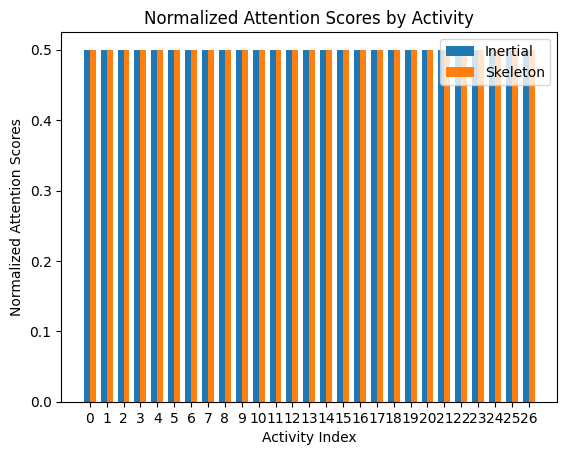

In [ ]:
num_activities = 27
attention_scores_inertial_by_activity = [np.mean(attention_scores_inertial_all[np.where(test_y11 == i)], axis=(0, 1)).item() for i in range(num_activities)]
attention_scores_skeleton_by_activity = [np.mean(attention_scores_skeleton_all[np.where(test_y11 == i)], axis=(0, 1)).item() for i in range(num_activities)]
normalized_attention_scores = [(inertial_score / (inertial_score + skeleton_score), skeleton_score / (inertial_score + skeleton_score)) for inertial_score, skeleton_score in zip(attention_scores_inertial_by_activity, attention_scores_skeleton_by_activity)]

fig, ax = plt.subplots()
activity_indices = np.arange(num_activities)
bar_width = 0.35

bar_inertial = ax.bar(activity_indices - bar_width / 2, [score[0] for score in normalized_attention_scores], bar_width, label='Inertial')
bar_skeleton = ax.bar(activity_indices + bar_width / 2, [score[1] for score in normalized_attention_scores], bar_width, label='Skeleton')

ax.set_xlabel('Activity Index')
ax.set_ylabel('Normalized Attention Scores')
ax.set_title('Normalized Attention Scores by Activity')
ax.set_xticks(activity_indices)
ax.legend()

plt.show()


In [ ]:
!pip install -U tensorflow-addons
import tensorflow_addons as tfa

In [ ]:
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)
#optimizer = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001)

combined_model.compile(optimizer=optimizer, loss=[tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)],metrics=[['accuracy']])
#combined_model.load_weights('/content/drive/MyDrive/transformer_HAR/fused_checkpoint/correlation_find_8_tuning.h5')
checkpoint_filepath = '/content/drive/MyDrive/transformer_HAR/fused_checkpoint/7.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=False
)

history = combined_model.fit([train_x11,train_x21],train_y11,validation_data =[[test_x11,test_x21],[test_y11]],epochs = 100,callbacks=[model_checkpoint_callback])

In [ ]:
class GateWeightUpdateCallback(tf.keras.callbacks.Callback):
    def __init__(self, gated_fusion_layer, model, checkpoint_filepath):
        super(GateWeightUpdateCallback, self).__init__()
        self.gated_fusion_layer = gated_fusion_layer
        self.model = model
        self.checkpoint_filepath = checkpoint_filepath
        self.best_val_accuracy = None

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get("val_accuracy")

        if self.best_val_accuracy is None or val_accuracy > self.best_val_accuracy:
            self.best_val_accuracy = val_accuracy
            self.gated_fusion_layer.gate.set_weights(self.gated_fusion_layer.gate.get_weights())
            self.model.save_weights(self.checkpoint_filepath)
    def on_epoch_end(self, epoch, logs=None):
        current_gate_weights = self.gated_fusion_layer.gate.get_weights()
        print("Before constraint:", current_gate_weights)
        current_gate_weights[0] = np.clip(current_gate_weights[0], self.min_value, self.max_value)
        self.gated_fusion_layer.gate.set_weights(current_gate_weights)
        print("After constraint:", self.gated_fusion_layer.gate.get_weights())

checkpoint_filepath = '/content/drive/MyDrive/transformer_HAR/fused_checkpoint/correlation_find_8_tuning.h5'    

gate_weight_update_callback = GateWeightUpdateCallback(gated_fusion, combined_model, checkpoint_filepath)
gate_weight_constraint_callback = GateWeightConstraintCallback(gated_fusion)

optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)
combined_model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
combined_model.load_weights('/content/drive/MyDrive/transformer_HAR/fused_checkpoint/correlation_find_8_tuning.h5')
history = combined_model.fit(
    [train_x11, train_x21], train_y11,
    validation_data=([test_x11, test_x21], test_y11),
    epochs=5, callbacks=[gate_weight_update_callback])


In [ ]:
def transfer_weights(source_model, target_model):
    source_layers = source_model.layers[:-1]
    target_layers = target_model.layers[:-1]

    if len(source_layers) != len(target_layers):
        print("Warning: The number of layers in source and target models do not match (excluding the last layer).")

    for target_layer in target_layers:
        try:
            source_layer = source_model.get_layer(target_layer.name)
            target_layer.set_weights(source_layer.get_weights())
        except ValueError:
            print(f"Skipping layer {target_layer.name}: not found in source model.")

combined_model.load_weights("/content/drive/MyDrive/transformer_HAR/fused_checkpoint/correlation_find_8_tuning.h5")
transfer_weights(source_model=combined_model, target_model=modified_model)


14/14 [==============================] - 6s 372ms/step
Skeleton weight: 0.699999988079071
Inertial weight: 0.30000001192092896


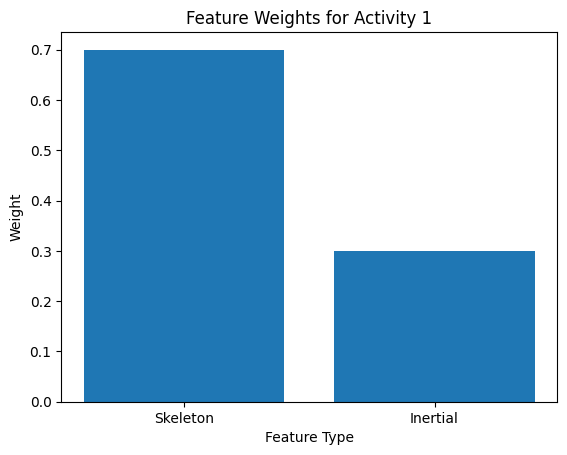

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have test_x11 and test_x21 as input data
attention_scores, gate_values = modified_model.predict([test_x11, test_x21])
combined_model = keras.Model(inputs=[inertial_model.input, skeleton_model.input], outputs=[outputs, attention_scores, gate_values])
_, attention_scores, gate_values = combined_model.predict([test_x11, test_x21])

activity_index = np.argmax(attention_scores)

# Get the gate values for the selected activity_index
gate_value_sample = gate_values[activity_index]

skeleton_weight = gate_value_sample.item()
inertial_weight = (1 - skeleton_weight)

print("Skeleton weight:", skeleton_weight)
print("Inertial weight:", inertial_weight)

plt.bar(["Skeleton", "Inertial"], [skeleton_weight, inertial_weight])
plt.xlabel("Feature Type")
plt.ylabel("Weight")
plt.title(f"Feature Weights for Activity {activity_index + 1}")
plt.show()


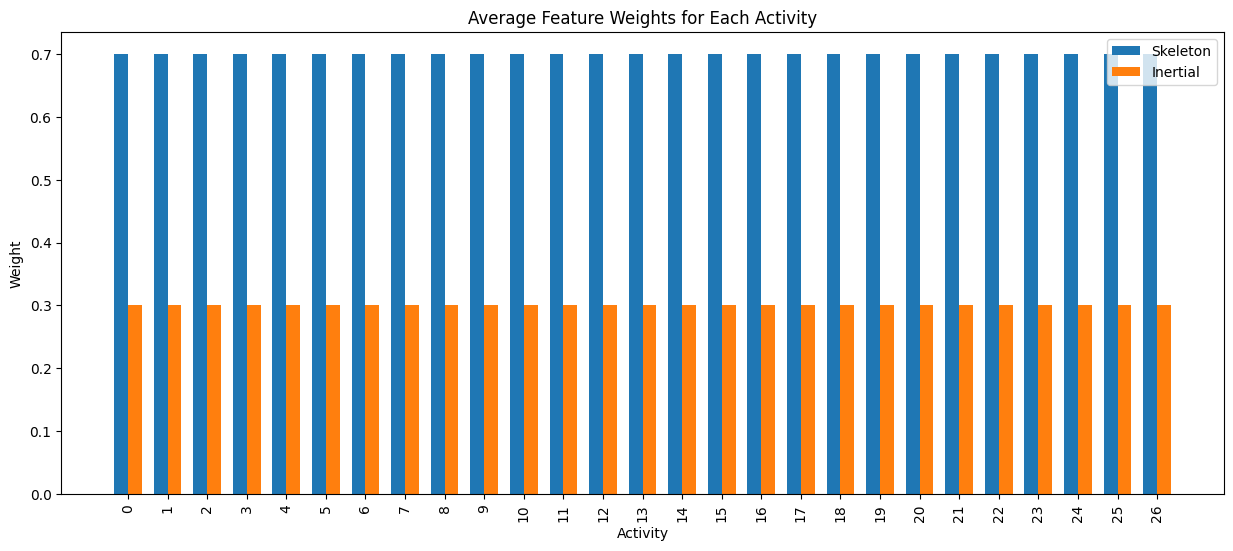

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

activity_labels_test_data = test_y11  # Replace this with your activity labels for the test data

unique_activities = sorted(set(activity_labels_test_data))
num_unique_activities = len(unique_activities)

skeleton_weights = []
inertial_weights = []

# Calculate the average weights for each unique activity
for activity in unique_activities:
    activity_indices = [i for i, label in enumerate(activity_labels_test_data) if label == activity]
    activity_gate_values = [gate_values[i].item() for i in activity_indices]
    
    mean_skeleton_weight = np.mean(activity_gate_values)
    mean_inertial_weight = 1 - mean_skeleton_weight
    
    skeleton_weights.append(mean_skeleton_weight)
    inertial_weights.append(mean_inertial_weight)

# Plot the skeleton and inertial weights for each unique activity
activity_indices = np.arange(num_unique_activities)
bar_width = 0.35

fig, ax = plt.subplots(figsize=(15, 6))  # Adjust the figure size here
bar_skeleton = ax.bar(activity_indices - bar_width / 2, skeleton_weights, bar_width, label="Skeleton")
bar_inertial = ax.bar(activity_indices + bar_width / 2, inertial_weights, bar_width, label="Inertial")

ax.set_xlabel("Activity")
ax.set_ylabel("Weight")
ax.set_title("Average Feature Weights for Each Activity")
ax.set_xticks(activity_indices)
ax.set_xticklabels(unique_activities, rotation=90)  # Set activity labels and rotate them 90 degrees
ax.legend()

plt.show()


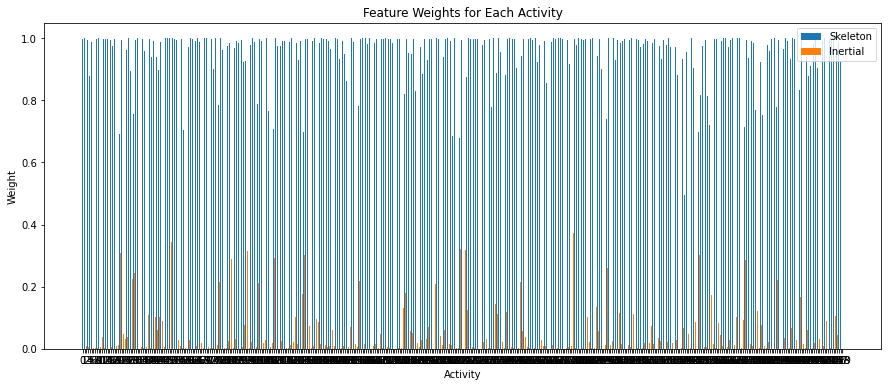

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


num_activities = len(gate_values)
skeleton_weights = []
inertial_weights = []

# Calculate weights for each activity
for activity_index in range(num_activities):
    gate_value_sample = gate_values[activity_index]
    skeleton_weight = gate_value_sample.item()
    inertial_weight = 1 - skeleton_weight
    
    skeleton_weights.append(skeleton_weight)
    inertial_weights.append(inertial_weight)

# Plot the skeleton and inertial weights for each activity
activity_indices = np.arange(num_activities)
bar_width = 0.35

fig, ax = plt.subplots(figsize=(15, 6))  # Adjust the figure size here
bar_skeleton = ax.bar(activity_indices - bar_width / 2, skeleton_weights, bar_width, label="Skeleton")
bar_inertial = ax.bar(activity_indices + bar_width / 2, inertial_weights, bar_width, label="Inertial")

ax.set_xlabel("Activity")
ax.set_ylabel("Weight")
ax.set_title("Feature Weights for Each Activity")
ax.set_xticks(activity_indices)
ax.legend()

plt.show()


In [ ]:
num_activities

430

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_avg_attention_scores(attention_scores, feature_labels):
    avg_scores = np.mean(attention_scores, axis=0)
    plt.figure(figsize=(8, 6))
    plt.bar(feature_labels, avg_scores)
    plt.xlabel('Features')
    plt.ylabel('Average Attention Score')
    plt.title('Average Attention Scores per Feature')
    plt.show()


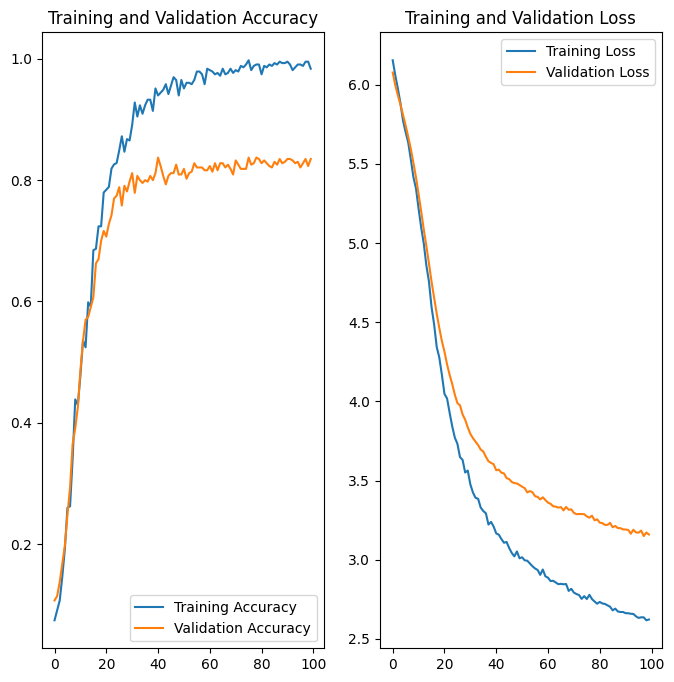

In [ ]:
epochs = 100
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
with open("/content/drive/MyDrive/transformer_HAR/fused_checkpoint/7_best_acc_history.txt", "w") as file:
    for item in acc:
        file.write(str(item) + "\n")
    file.write("\n")
    for item in val_acc:
        file.write(str(item) + "\n")
    file.write("\n")
    for item in loss:
        file.write(str(item) + "\n")
    file.write("\n")
    for item in val_loss:
        file.write(str(item) + "\n")

In [ ]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
predictions = combined_model.predict(x=[test_x11,test_x21],batch_size=8,verbose=0)
rounded_predictions = np.argmax(predictions,axis=-1)
cm = confusion_matrix(y_true=test_y11, y_pred=rounded_predictions)

In [ ]:
def plot_confusion_matrix(cm, classes = None,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
#    tick_marks = np.arange(len(classes))
#    plt.xticks(tick_marks, classes, rotation=45)
#    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0 15  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  2 12  1  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  2  0  0  0 13  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  1  0  2  0  2  0  0  5  0  1  3  0  0  0  1  0  0  0  0  0  0  0  0
   0  1  0]
 [ 0  4  0  3  0  0  0  0  0  5  0  2  0  0  0  0  0  0  0  0  0  2  0  0
   0  0  0]
 [ 0  2  1  2  0  0  0  0  1  3  6  0  0  0  0  0  0  0  0  1  0  0  0  0
   0  0  0]
 [ 0  0  0  0 

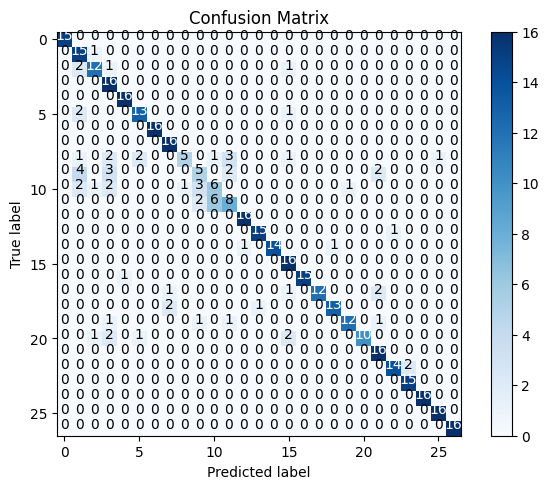

In [ ]:
cm_plot_labels = []
plot_confusion_matrix(cm=cm, title='Confusion Matrix')

In [ ]:
count = 0
true = 0
for i in range(27):
  for j in range(len(test_y11)):
    if test_y11[j] == i:
      count += 1
      if test_y11[j] - rounded_predictions[j] == 0:
        true += 1
  acc = true / count
  print(acc)
  count = 0
  true = 0

1.0
0.9375
0.75
1.0
1.0
0.8125
1.0
1.0
0.3125
0.3125
0.375
0.5
1.0
0.9375
0.875
1.0
0.9375
0.75
0.8125
0.75
0.625
1.0
0.875
1.0
1.0
1.0
1.0


In [ ]:

  print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
